In [ ]:
import pickle

file_path = "/Users/lune/ISP/rolling-in-the-deep/experiments/2025-W3-01-13/results/results.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

print(data)

{'folds': [{'fold': 0, 'epochs': [{'epoch': 0, 'training': {'loss': tensor(0.3233, requires_grad=True), 'accuracy': 0.7484375, 'precision': 0.5317953884551095, 'recall': 0.5441481128355433, 'f1': 0.5247518470581647, 'auc_ovr': 0.8073786286357306, 'auc_ovo': 0.7617671898817616}, 'validation': {'loss': tensor(7.8031), 'accuracy': 0.5875, 'precision': 0.19583333333333333, 'recall': 0.3333333333333333, 'f1': 0.24671916010498687, 'auc_ovr': 0.5231555659836418, 'auc_ovo': 0.5502454991816695}}]}, {'fold': 1, 'epochs': [{'epoch': 0, 'training': {'loss': tensor(0.5642, requires_grad=True), 'accuracy': 0.378125, 'precision': 0.42045104744858647, 'recall': 0.4937802590617604, 'f1': 0.3232766141030399, 'auc_ovr': 0.6364007400927177, 'auc_ovo': 0.676715130267409}, 'validation': {'loss': tensor(1.0648), 'accuracy': 0.4125, 'precision': 0.13749999999999998, 'recall': 0.3333333333333333, 'f1': 0.19469026548672563, 'auc_ovr': 0.26550585975811924, 'auc_ovo': 0.30064081676984905}}]}, {'fold': 2, 'epochs'

In [22]:
validation_accuracy_last_epoch = [
    fold['epochs'][-1]['validation']['accuracy']  # Get the accuracy from the last epoch of each fold
    for fold in data['folds']
]

In [23]:
validation_accuracy_last_epoch

[0.5875, 0.4125, 0.58125, 0.58125, 0.58125]

In [ ]:
from scipy.stats import wilcoxon

performance_A = [0.85, 0.88, 0.89, 0.87, 0.90] 
performance_B = [0.84, 0.87, 0.88, 0.86, 0.89]

stat, p = wilcoxon(performance_A, performance_B)

print(f"Test Statistic: {stat}")
print(f"P-value: {p}")

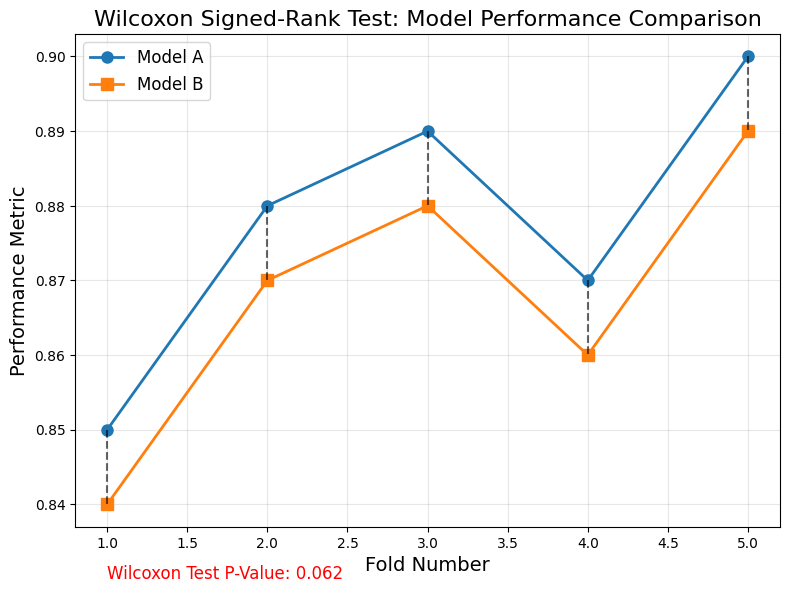

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Example data
folds = np.arange(1, 6)  # 5-folds
performance_A = [0.85, 0.88, 0.89, 0.87, 0.90]  # Model A performance
performance_B = [0.84, 0.87, 0.88, 0.86, 0.89]  # Model B performance

# Perform the Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(performance_A, performance_B)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot performances
plt.plot(folds, performance_A, 'o-', label='Model A', linewidth=2, markersize=8)
plt.plot(folds, performance_B, 's-', label='Model B', linewidth=2, markersize=8)

# Connect paired performances with lines
for i in range(len(folds)):
    plt.plot([folds[i], folds[i]], [performance_A[i], performance_B[i]], 'k--', alpha=0.6)

# Add labels and title
plt.xlabel('Fold Number', fontsize=14)
plt.ylabel('Performance Metric', fontsize=14)
plt.title('Wilcoxon Signed-Rank Test: Model Performance Comparison', fontsize=16)

# Annotate p-value
plt.text(1, min(min(performance_A), min(performance_B)) - 0.01,
         f'Wilcoxon Test P-Value: {p_value:.3f}', fontsize=12, color='red')

# Show legend
plt.legend(fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


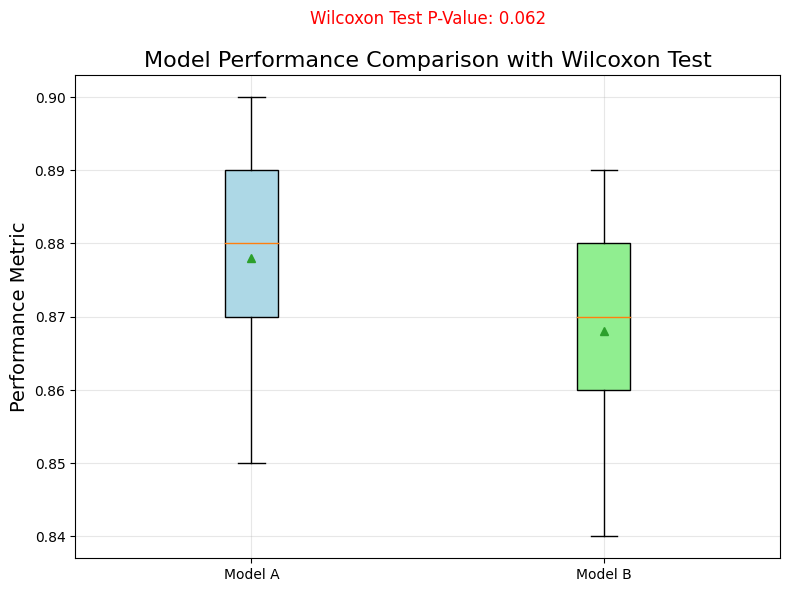

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Example data
performance_A = [0.85, 0.88, 0.89, 0.87, 0.90]  # Model A performance
performance_B = [0.84, 0.87, 0.88, 0.86, 0.89]  # Model B performance

# Perform the Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(performance_A, performance_B)

# Create the boxplot
plt.figure(figsize=(8, 6))
data = [performance_A, performance_B]
labels = ['Model A', 'Model B']

# Boxplot
box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)

# Customize boxplot appearance
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add p-value annotation
y_max = max(max(performance_A), max(performance_B)) + 0.01
plt.text(1.5, y_max, f'Wilcoxon Test P-Value: {p_value:.3f}', fontsize=12, ha='center', color='red')

# Add labels and title
plt.ylabel('Performance Metric', fontsize=14)
plt.title('Model Performance Comparison with Wilcoxon Test', fontsize=16)

# Add grid
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


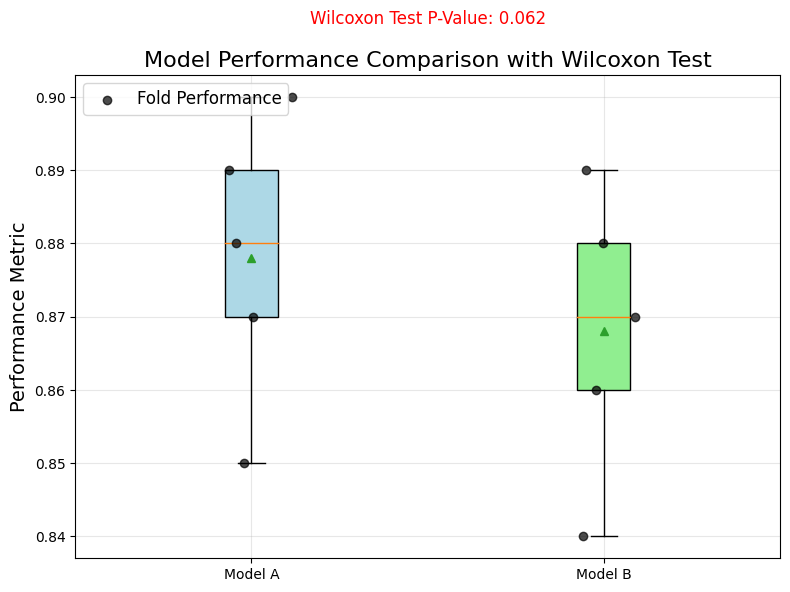

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Example data
performance_A = [0.85, 0.88, 0.89, 0.87, 0.90]  # Model A performance
performance_B = [0.84, 0.87, 0.88, 0.86, 0.89]  # Model B performance

# Perform the Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(performance_A, performance_B)

# Create the boxplot
plt.figure(figsize=(8, 6))
data = [performance_A, performance_B]
labels = ['Model A', 'Model B']

# Boxplot
box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)

# Customize boxplot appearance
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Overlay individual data points
jitter = 0.05  # Small random noise to spread points
for i, performances in enumerate(data):
    x = np.random.normal(i + 1, jitter, size=len(performances))  # Jittered x positions
    plt.scatter(x, performances, color='black', alpha=0.7, zorder=3, label='Fold Performance' if i == 0 else None)

# Add p-value annotation
y_max = max(max(performance_A), max(performance_B)) + 0.01
plt.text(1.5, y_max, f'Wilcoxon Test P-Value: {p_value:.3f}', fontsize=12, ha='center', color='red')

# Add labels and title
plt.ylabel('Performance Metric', fontsize=14)
plt.title('Model Performance Comparison with Wilcoxon Test', fontsize=16)

# Add legend and grid
plt.legend(fontsize=12, loc='upper left')
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
